### **Contents**

1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

****

### Business Problem Understanding


Sebagai pemain utama di pasar mobil bekas Arab Saudi, CarSwitch.com beroperasi di sektor yang sangat kompetitif dan berkembang pesat. Selama dekade terakhir, kepemilikan mobil di Arab Saudi terus meningkat, dengan banyak keluarga memiliki lebih dari satu kendaraan. Hal ini mendorong permintaan yang kuat untuk mobil bekas yang harganya lebih terjangkau.

Namun, membeli atau menjual mobil bekas bisa menjadi tugas yang menantang. Tantangan terbesar bagi pengguna platform kami, baik pembeli maupun penjual, adalah menentukan harga pasar yang wajar. Banyak pengguna tidak memiliki pengalaman untuk menilai kondisi mobil secara akurat atau memahami tren pasar yang dinamis, sehingga membutuhkan sebuah metode yang andal dan cerdas untuk memberikan estimasi harga.

Problem Statement
Di CarSwitch, kami mengidentifikasi bahwa salah satu friksi terbesar yang menghambat kecepatan transaksi adalah ketidakpastian harga. Penjual khawatir menjual terlalu murah, sementara pembeli takut membayar terlalu mahal. Situasi ini membutuhkan lebih dari sekadar "daftar harga"; ia membutuhkan model prediktif yang dapat memberikan estimasi harga yang akurat berdasarkan data historis dan spesifikasi unik setiap kendaraan.

Tantangan utamanya tidak hanya memprediksi harga, tetapi juga akurat di semua segmen, mulai dari mobil ekonomi seharga 20,000 SAR hingga SUV mewah seharga 300,000 SAR. Kesalahan prediksi persentase kecil pada mobil mewah mungkin dapat diterima, tetapi kesalahan persentase yang sama pada mobil murah dapat merusak kepercayaan pengguna sepenuhnya.

Goal
Berdasarkan permasalahan tersebut, tujuan proyek ini adalah untuk mengembangkan 'CarSwitch Smart Pricing Tool': sebuah tool internal berbasis machine learning yang dapat memprediksi harga mobil bekas dengan andal. Tujuannya adalah untuk:

1. Memberdayakan Penjual: Memberikan rekomendasi harga yang kompetitif dan wajar berdasarkan data pasar terkini untuk mempercepat penjualan.

2. Meningkatkan Kepercayaan Pembeli: Memberikan acuan harga yang transparan untuk membantu pembeli membuat keputusan yang tepat dan merasa aman bertransaksi di platform CarSwitch.

Analytic Approach
Untuk mencapai tujuan ini, kami menganalisis data historis transaksi mobil bekas untuk menemukan pola-pola yang memengaruhi harga. Pendekatan yang kami ambil adalah membangun model regresi.

Namun, analisis awal menunjukkan bahwa satu model tunggal ("generalis") kesulitan untuk akurat di semua segmen harga. Oleh karena itu, kami mengembangkan pendekatan yang lebih canggih, yaitu arsitektur dua model "spesialis":

1. Satu model yang secara khusus dilatih untuk memprediksi harga mobil segmen rendah.

2. Satu model lain yang dilatih untuk memprediksi harga mobil segmen tinggi.

Sistem ini menggunakan sebuah "Model Router" yang secara cerdas akan mengarahkan setiap mobil baru ke model spesialis yang tepat, memastikan akurasi maksimal di seluruh rentang harga.

Metric Evaluation
Meskipun kami memantau berbagai metrik, pemilihan metrik evaluasi utama kami didasarkan langsung pada masalah bisnis:

1. MAPE (Mean Absolute Percentage Error): Ini adalah fokus utama kami. Di CarSwitch, pengalaman dan kepercayaan pengguna adalah segalanya. Kesalahan prediksi 5,000 SAR pada mobil seharga 20,000 SAR (MAPE 25%) jauh lebih merusak kepercayaan daripada kesalahan 5,000 SAR pada mobil seharga 200,000 SAR (MAPE 2.5%). Oleh karena itu, menekan MAPE serendah mungkin, terutama di segmen harga rendah, adalah tujuan bisnis utama kami.

2. MAE (Mean Absolute Error): Metrik ini kami gunakan sebagai target optimasi selama hyperparameter tuning. MAE memberikan gambaran rata-rata kesalahan dalam SAR dan lebih stabil secara matematis daripada MAPE, menjadikannya proksi yang baik untuk meningkatkan akurasi secara keseluruhan.

3. R-squared (R2 Score): Kami menggunakan metrik ini sebagai indikator umum untuk memastikan model kami dapat menjelaskan sebagian besar varians dalam data harga. Karena model akhir kami (XGBoost) bersifat non-linear, R2 lebih berfungsi sebagai panduan daripada metrik penentu utama.

### Data Understanding

Dataset ini merupakan data mobil bekas yang ada di website kami (carswitch.com)

**Attributes Information**

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| Type | Text | Nama Brand Mobil |
| Region | Text | Wilayah tempat mobil bekas ditawarkan untuk dijual |
| Make | Text | Nama Perusahaan Mobil |
| Gear_Type | Text | Automatic/Manual |
| Origin | Text | Negara importir (Teluk / Saudi / Lainnya) |
| Option | Text | Full Options / Semi-Full / Standard |
| Year | Integer | Tahun Pembuatan |
| Engine_Size | Float | Ukuran Mesin Mobil |
| Mileage | Integer | Jarak rata-rata yang ditempuh mobil(km) |
| Negotiable | Boolean | Jika Benar, harganya 0. Harga bisa negoisasi |
| Price | Integer | Harga mobil bekas(SAR) |


In [ ]:
# Import library yang dibutuhkan

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
import joblib
from category_encoders import TargetEncoder


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Memuat data
df = pd.read_csv('data_saudi_used_cars.csv')
df.head()



,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


In [13]:
df.describe()


,Year,Engine_Size,Mileage,Price
count,5624.000000,5624.000000,5.624000e+03,5624.000000
mean,2014.101885,3.295430,1.509234e+05,53074.058144
std,5.791606,1.515108,3.828360e+05,70155.340614
min,1963.000000,1.000000,1.000000e+02,0.000000
25%,2012.000000,2.000000,3.800000e+04,0.000000
50%,2016.000000,3.000000,1.030000e+05,36500.000000
75%,2018.000000,4.500000,1.960000e+05,72932.500000
max,2022.000000,9.000000,2.000000e+07,850000.000000


In [14]:
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

Dari sini kita bisa lihat bahwa dataset ini memiliki 11 kolom dan tanpa missing values,tetapi terdapat nilai nilai yang tidak masuk akal(akan kita bahas nanti). Karena kita ingin memprediksi harga, maka 10 kumpulan kolom selain Price akan dijadikan sebagai fitur sedangkan kolom Price akan dijadikan sebagai Target 

### Exploratory Data Analysis

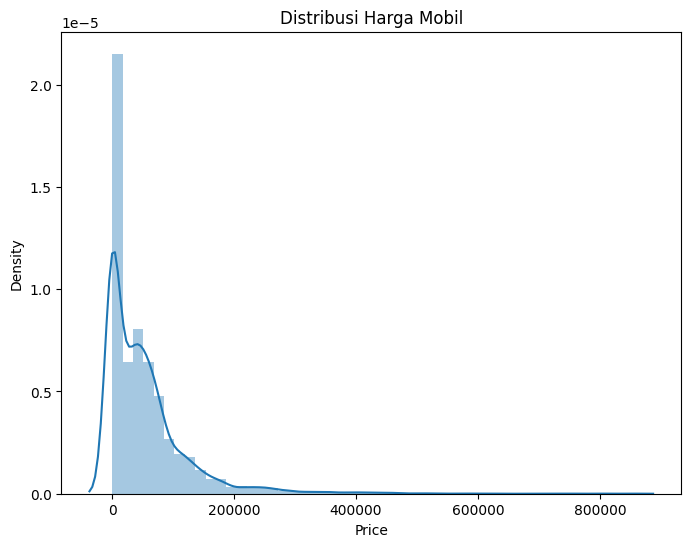

In [19]:
# Cek apakah kolom harga terdistribusi normal atau tidak
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.distplot(df['Price'])
plt.title('Distribusi Harga Mobil')
plt.show()

Dari grafik ini kita bisa menyimpulkan bahwa fitur "Price" memiliki  "Right-skewed distribution" atau positively skewed yang jauh sekali dari normal berarti nilai : Mean > Median > Mode. karena variabel target distribusinya sangat jauh dari normal atau sangat skewed maka saya memutuskan untuk tidak menggunakan regresi linear (Ordinary Least Squares, OLS), karena tidak ideal 

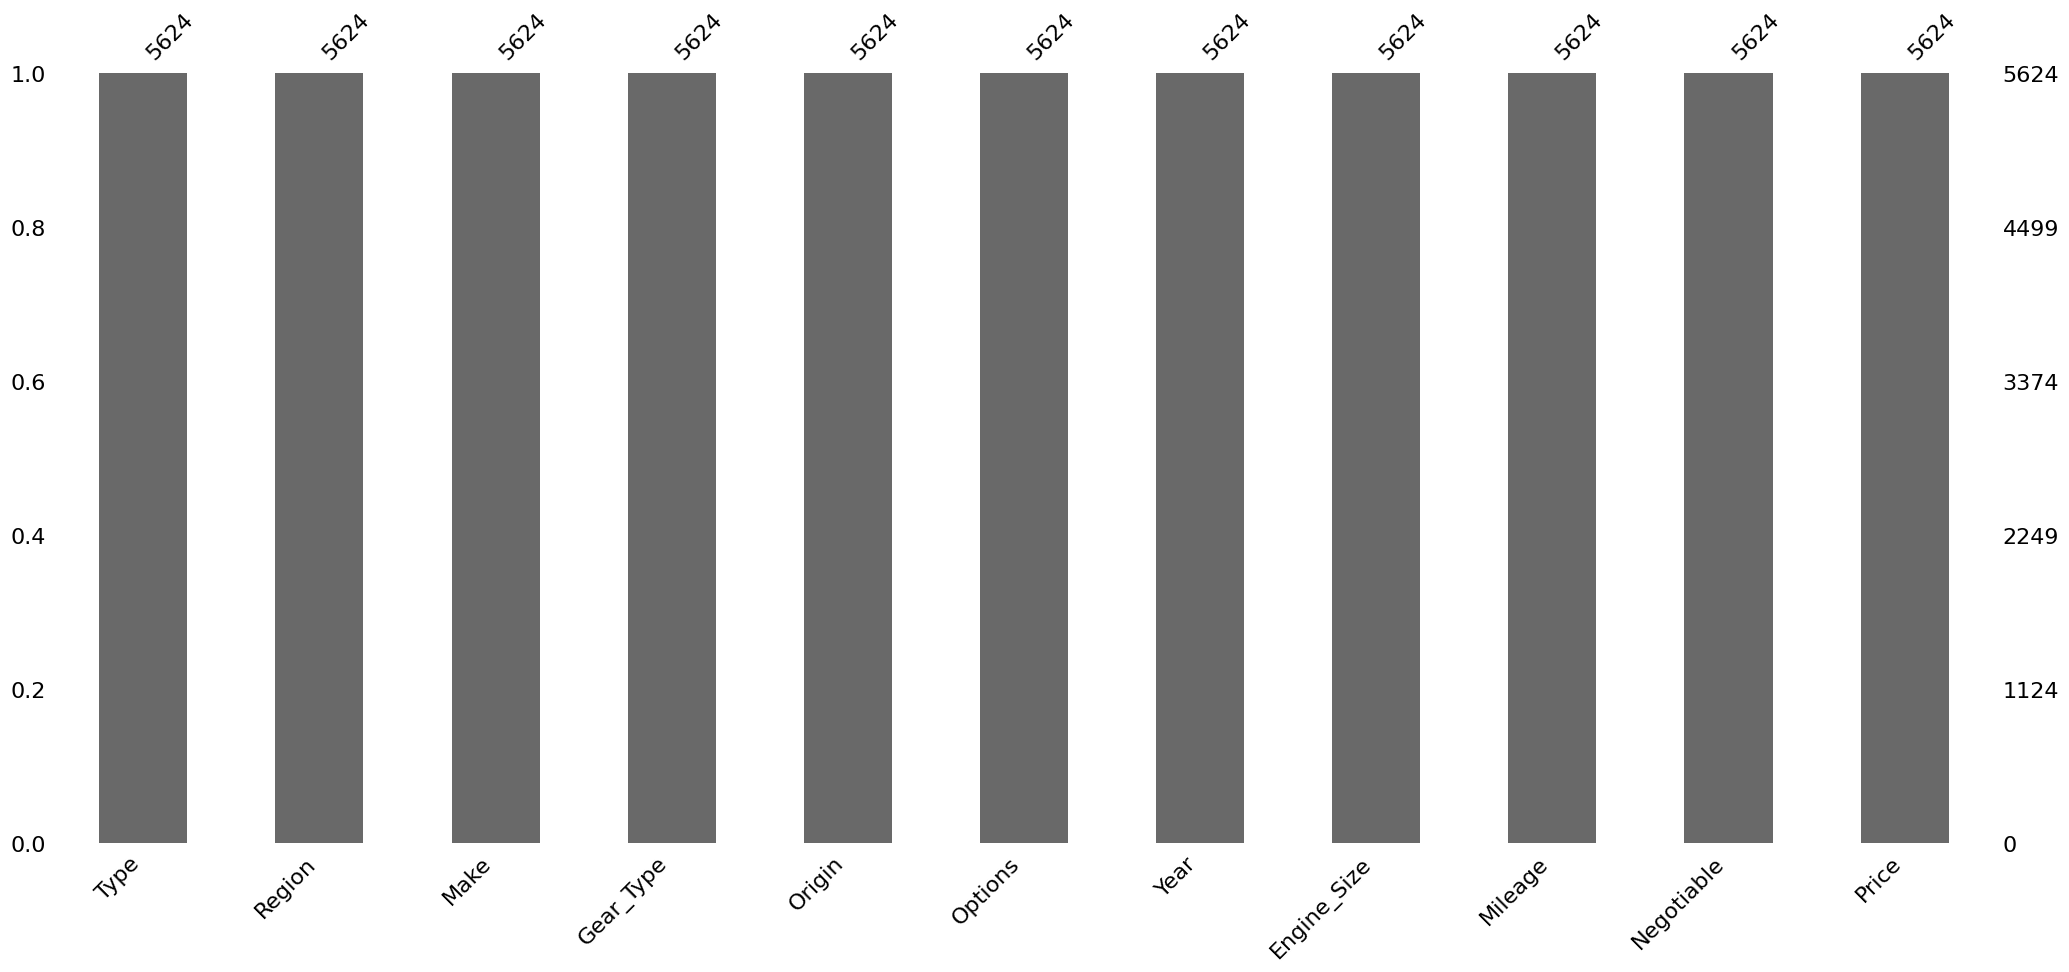

In [22]:
import missingno as msno

# Visualisasi missing values
msno.bar(df)
plt.show()

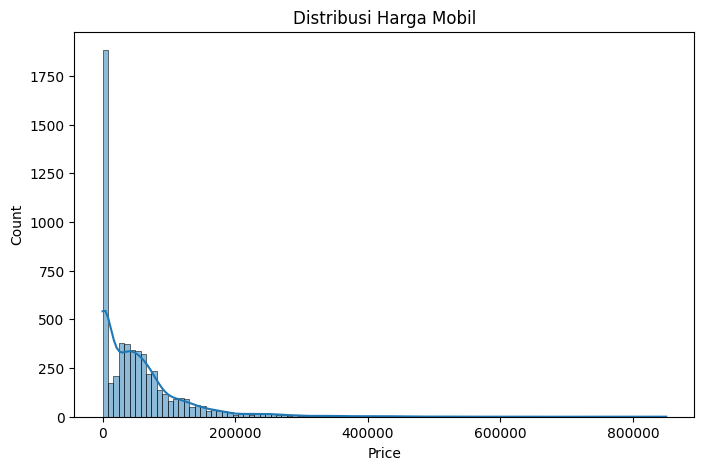

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cek Distribusi Target (Price)

target_col = "Price"  
plt.figure(figsize=(8,5))
sns.histplot(df[target_col], kde=True)
plt.title("Distribusi Harga Mobil")
plt.show()



Dari grafik ini kita bisa menyimpulkan bahwa fitur "Price" memiliki  "Right-skewed distribution" atau positively skewed yang jauh sekali dari normal berarti nilai : Mean > Median > Mode. karena variabel target distribusinya sangat jauh dari normal atau sangat skewed maka saya memutuskan untuk tidak menggunakan regresi linear (Ordinary Least Squares, OLS), karena tidak ideal 

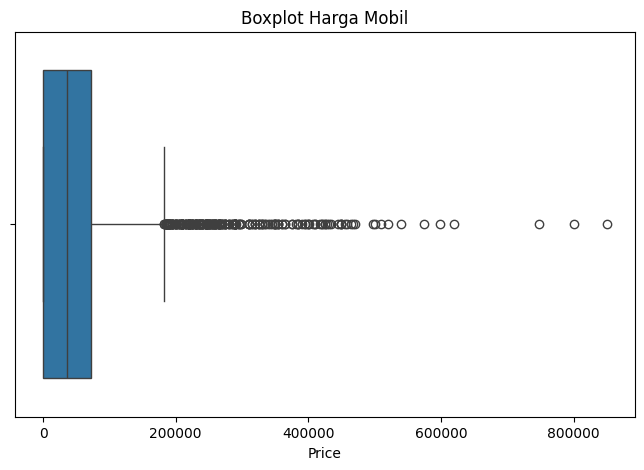

In [ ]:
# Cek Outlier Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x=df[target_col])
plt.title("Boxplot Harga Mobil")
plt.show()


Bisa kita lihat disini terdapat banyak outlier, namun outlier ini masih masuk akal karena harga mobil sangat bervariasi. Sebagian harga mobil bekas ini berada di kisaran harga yang rendah, bsia dilihat dari Mayoritas data terkonsentrasi di sisi kiri (Harga relatif rendah), terlihat dari kotak IQR yang kecil dan dekat ke angka nol. median harga cukup rendah karena garis median posisinya dekat ke harga rendah, menandakan separuh mobil berada di kisaran harga murah 


In [ ]:
# Kardinalitas Kolom Kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns
print("=== Kardinalitas Kategori ===")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


=== Kardinalitas Kategori ===
Type: 347 unique values
Region: 27 unique values
Make: 58 unique values
Gear_Type: 2 unique values
Origin: 4 unique values
Options: 3 unique values


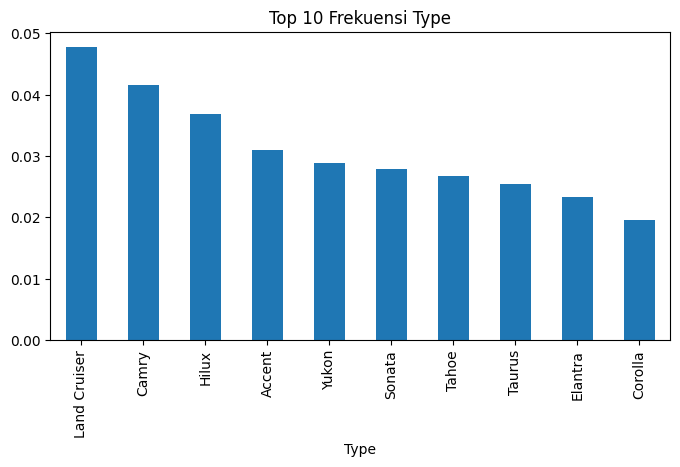

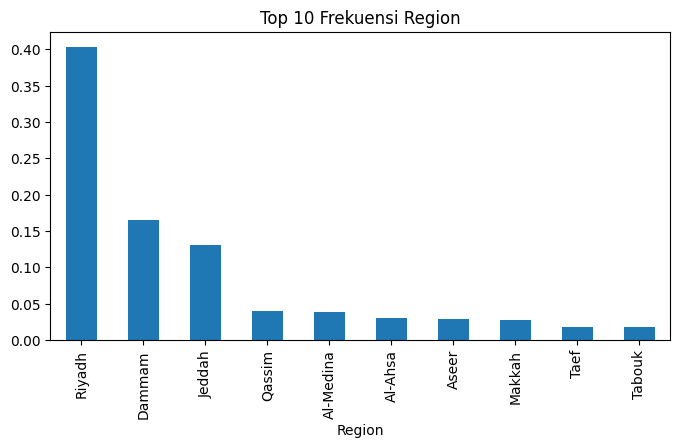

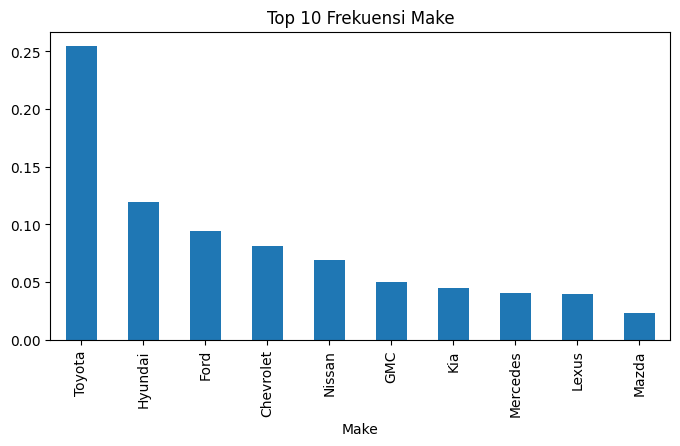

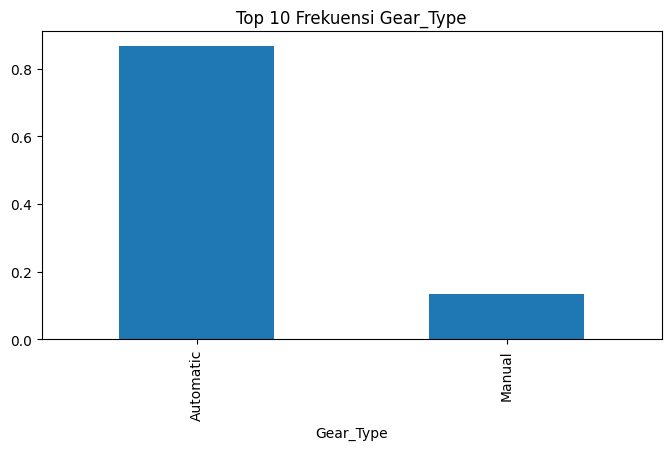

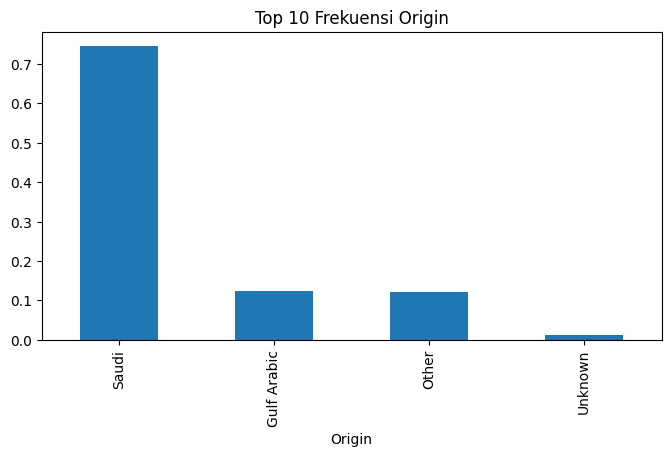

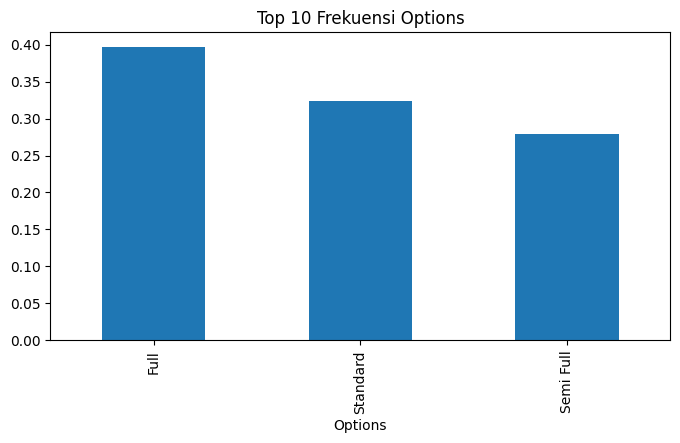

In [26]:
# === 7. Analisis Frekuensi Kategori ===
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    df[col].value_counts(normalize=True).head(10).plot(kind='bar')
    plt.title(f"Top 10 Frekuensi {col}")
    plt.show()

Berdasarkan grafik frekuensi kategori, terlihat bahwa pada variabel Type, model kendaraan yang paling banyak muncul adalah Land Cruiser, disusul oleh Camry dan Hilux. Pada variabel Region, wilayah Riyadh mendominasi secara signifikan dengan proporsi lebih dari 40%, diikuti Dammam dan Jeddah, menunjukkan konsentrasi data yang tinggi di beberapa kota besar. Untuk Make, merek Toyota memiliki frekuensi tertinggi, diikuti oleh Hyundai dan Ford, yang menandakan dominasi merek tertentu di pasar. Pada variabel Gear_Type, transmisi otomatis sangat dominan dibanding manual, sedangkan untuk Origin, kendaraan asal Saudi mendominasi dibanding asal lain. Sementara itu, pada variabel Options, kategori Full menjadi yang paling banyak muncul, diikuti oleh Standard dan Semi Full. Pola ini mengindikasikan bahwa dataset cenderung terkonsentrasi pada beberapa kategori populer, baik dari sisi tipe, merek, lokasi, maupun fitur kendaraan.

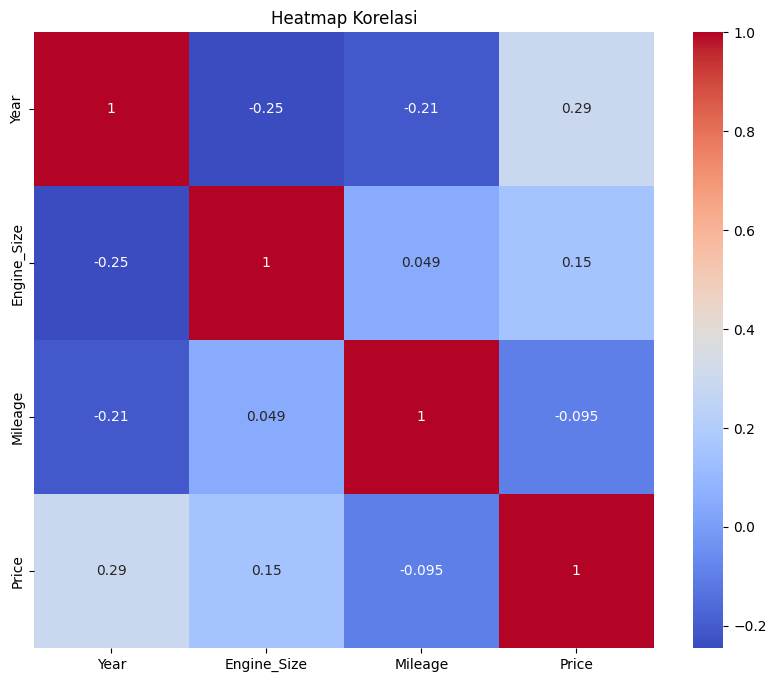

In [27]:
# === 8. Korelasi Numerik ===
numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi")
plt.show()


Berdasarkan heatmap korelasi numerik, fitur yang memiliki hubungan paling kuat dengan harga mobil (Price) adalah Year dengan korelasi positif sedang (0.29), menunjukkan bahwa mobil yang lebih baru cenderung memiliki harga lebih tinggi. Engine_Size memiliki korelasi positif lemah (0.15) yang mengindikasikan bahwa kapasitas mesin yang lebih besar sedikit meningkatkan harga, sedangkan Mileage memiliki korelasi negatif lemah (-0.095) yang berarti semakin tinggi jarak tempuh, harga cenderung sedikit menurun. Hubungan antar fitur numerik lainnya relatif rendah sehingga tidak ditemukan indikasi multikolinearitas yang signifikan.

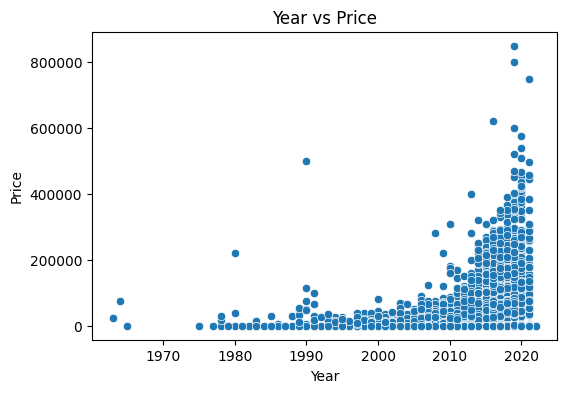

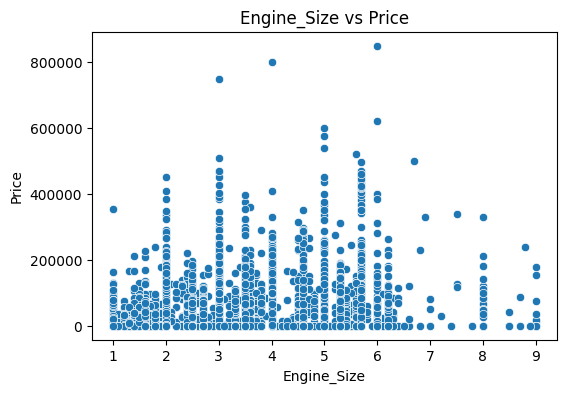

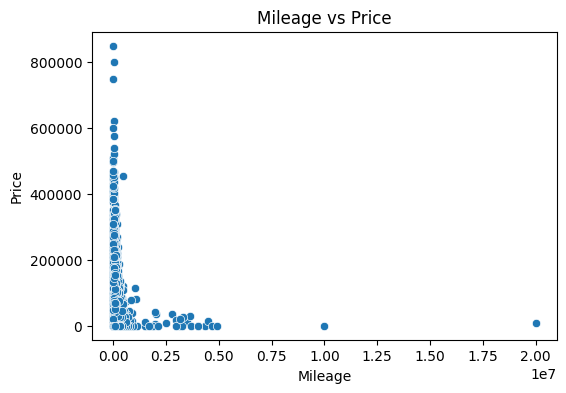

In [28]:
# === 9. Hubungan Target dengan Fitur Numerik ===
for col in numeric_cols:
    if col != target_col:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[col], y=df[target_col])
        plt.title(f"{col} vs {target_col}")
        plt.show()


Berdasarkan grafik hubungan antara fitur numerik dengan harga (Price), terlihat bahwa mobil yang lebih baru (Year lebih tinggi) cenderung memiliki harga yang lebih tinggi, meskipun ada beberapa outlier pada tahun lama dengan harga tinggi. Ukuran mesin (Engine_Size) tidak menunjukkan hubungan yang jelas dengan harga, karena mobil dengan berbagai ukuran mesin tersebar di seluruh rentang harga. Untuk jarak tempuh (Mileage), mayoritas mobil dengan harga tinggi memiliki mileage yang rendah, sementara mileage yang sangat tinggi umumnya berkorelasi dengan harga rendah, meskipun terdapat beberapa outlier ekstrem. Secara keseluruhan, Year menunjukkan hubungan positif dengan harga, Mileage cenderung menunjukkan hubungan negatif, sedangkan Engine_Size tidak memiliki pola yang kuat.

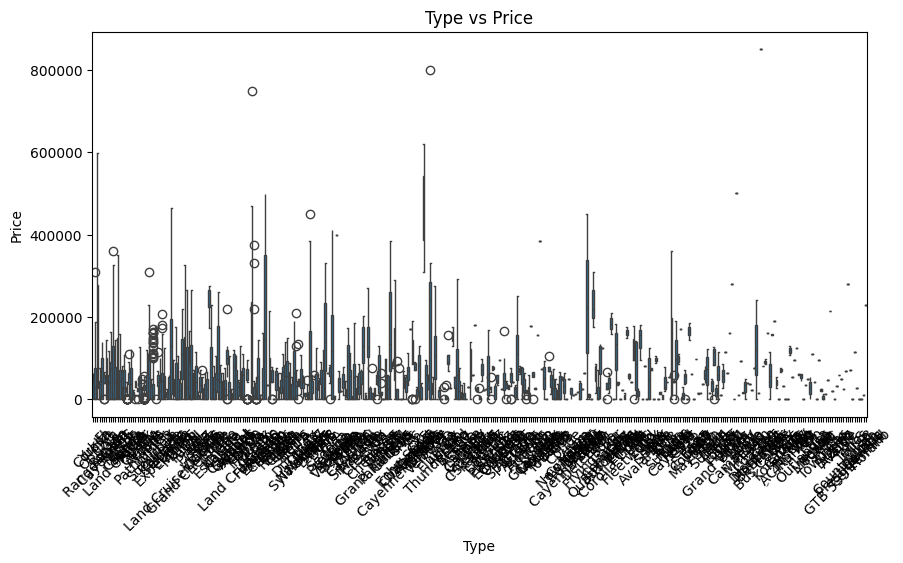

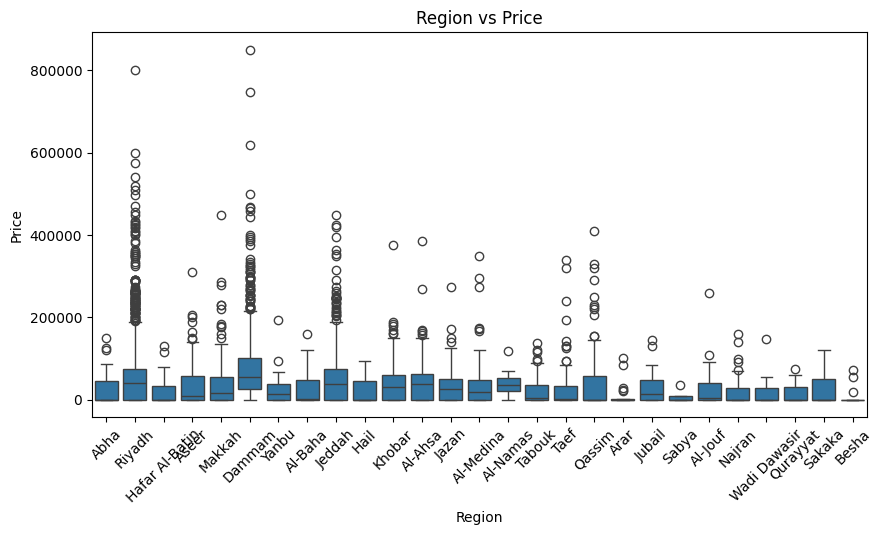

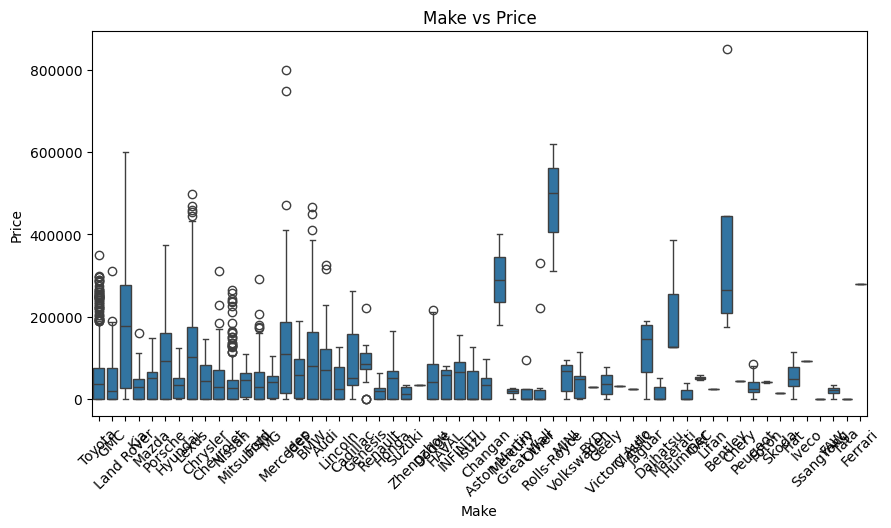

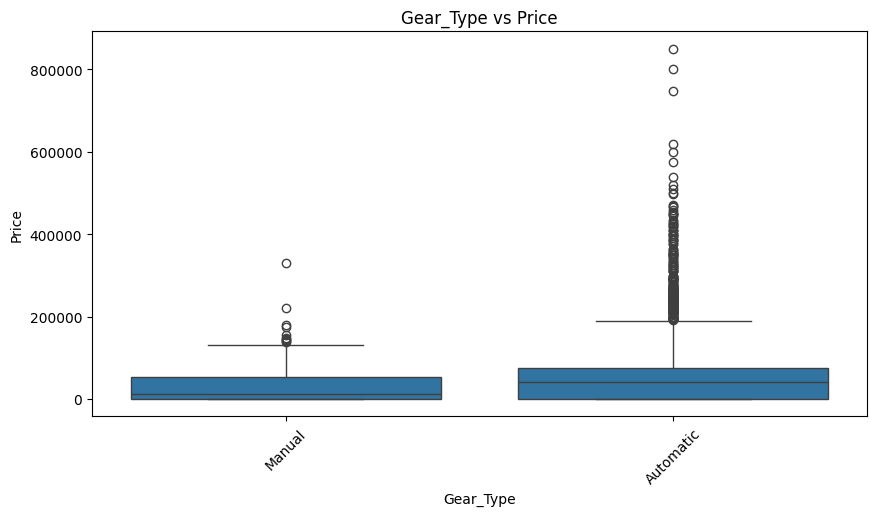

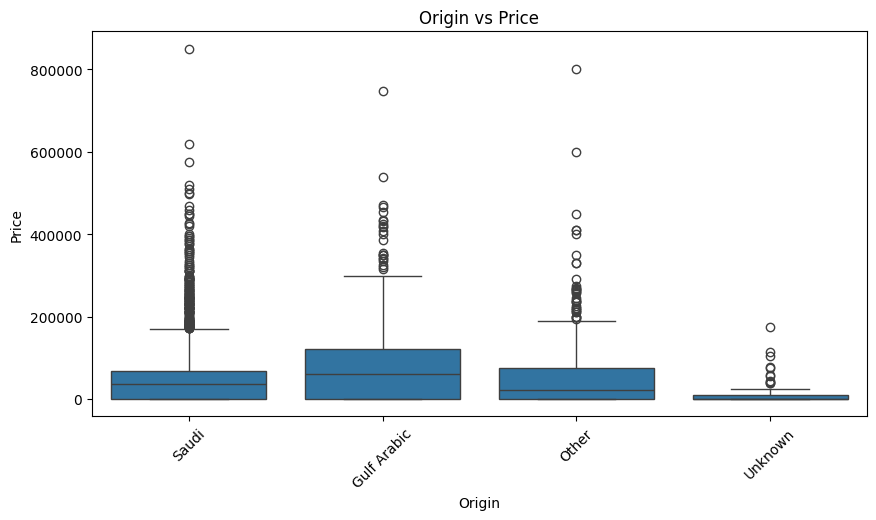

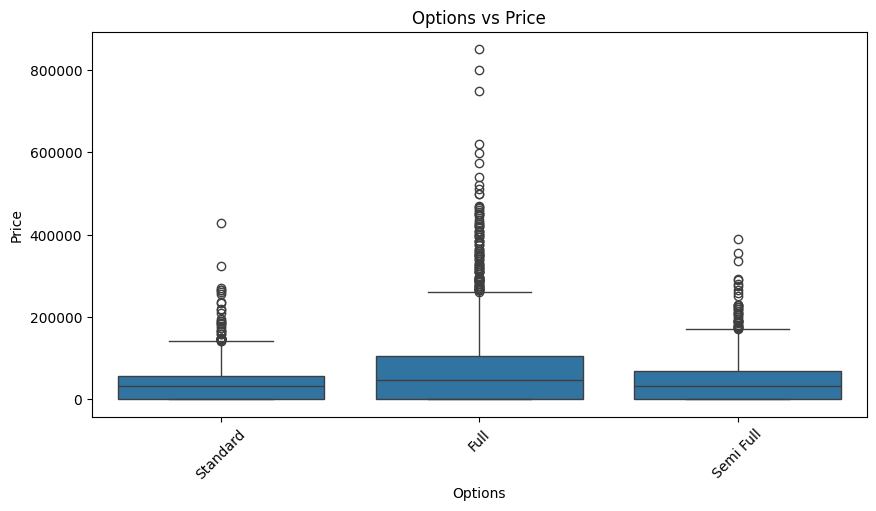

In [29]:
# === 10. Hubungan Target dengan Fitur Kategorikal ===
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=df[col], y=df[target_col])
    plt.xticks(rotation=45)
    plt.title(f"{col} vs {target_col}")
    plt.show()


Berdasarkan grafik hubungan antara target dengan fitur kategorik, terlihat bahwa beberapa kategori memiliki perbedaan nilai target yang cukup signifikan, menunjukkan adanya potensi pengaruh kategori tersebut terhadap variasi target. Beberapa fitur kategorik menampilkan pola distribusi yang jelas, di mana kelompok tertentu cenderung memiliki nilai target lebih tinggi atau lebih rendah dibanding kelompok lainnya, yang dapat mengindikasikan hubungan yang kuat. Namun, ada juga fitur yang distribusinya relatif merata antar kategori, sehingga kemungkinan pengaruhnya terhadap target lebih kecil. Temuan ini dapat dimanfaatkan pada tahap feature engineering, misalnya dengan melakukan encoding yang tepat atau menggabungkan kategori dengan karakteristik serupa untuk meningkatkan kinerja model.

#### Data Preprocessing

Pada tahap ini, dilakukan proses data cleaning dan feature engineering untuk mempersiapkan dataset yang siap digunakan pada proses analisis maupun pemodelan. Langkah pertama adalah memfilter data berdasarkan kriteria tertentu, seperti hanya menyertakan data dengan harga di atas 5000, menghapus fitur yang kurang relevan seperti Region dan Negotiable, serta menghapus data dengan nilai Mileage yang tidak diketahui. Selanjutnya, dilakukan konversi tipe data menjadi numerik pada kolom Mileage dan Engine_Size, menghapus entri dengan tipe Furniture, serta menghilangkan data duplikat. Nilai yang hilang pada fitur numerik (Engine_Size, Mileage, Year) diimputasi menggunakan nilai median, sedangkan pada fitur kategorik (Make, Type, Gear_Type, Origin, Options) diimputasi menggunakan nilai modus. Data dengan nilai Mileage ekstrem di atas 1 juta juga dihapus.

Pada tahap feature engineering, ditambahkan fitur-fitur turunan seperti Car_Age (umur kendaraan), Mileage_per_Year, pengelompokan merek (Brand_Tier) dan tipe mobil (Type_Tier) berdasarkan segmentasi luxury, premium, atau economy. Selain itu, dibuat kategori umur kendaraan (Age_Category), kategori jarak tempuh (Mileage_Category), kategori kapasitas mesin (Engine_Category), serta fitur interaksi antara umur dan jarak tempuh (Age_Mileage_Interaction). Transformasi log pada harga (Price_log) juga diterapkan untuk menormalkan distribusi. Fitur Year dihapus karena sudah direpresentasikan oleh Car_Age. Dengan langkah ini, data menjadi lebih bersih, konsisten, dan kaya akan informasi untuk tahap analisis berikutnya.

In [ ]:

df_cleaned = df[df['Price'] > 5000].copy() 
df_cleaned.drop(columns=['Region', 'Negotiable'], inplace=True)
df_cleaned = df_cleaned[df_cleaned['Mileage'] != 'Unknown']
df_cleaned['Mileage'] = pd.to_numeric(df_cleaned['Mileage'], errors='coerce')
df_cleaned['Engine_Size'] = pd.to_numeric(df_cleaned['Engine_Size'], errors='coerce')
df_cleaned = df_cleaned[df_cleaned['Type'] != 'Furniture']
df_cleaned.drop_duplicates(inplace=True)
for col in ['Engine_Size', 'Mileage', 'Year']:
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
for col in ['Make', 'Type', 'Gear_Type', 'Origin', 'Options']:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
df_cleaned = df_cleaned[df_cleaned['Mileage'] < 1000000]

# Fungsi Feature Engineering Final
def create_enhanced_features(df):
    df_eng = df.copy()
    current_year = pd.to_datetime('today').year
    df_eng['Car_Age'] = current_year - df_eng['Year']
    df_eng['Mileage_per_Year'] = df_eng['Mileage'] / (df_eng['Car_Age'] + 1)
    luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Infiniti', 'Cadillac', 'Jaguar', 'Land Rover', 'Porsche', 'GMC']
    premium_brands = ['Toyota', 'Honda', 'Nissan', 'Ford', 'Chevrolet', 'Hyundai', 'Kia', 'Mazda', 'Jeep', 'Dodge']
    def get_brand_tier(make):
        if make in luxury_brands: return 'luxury'
        elif make in premium_brands: return 'premium'
        else: return 'economy'
    df_eng['Brand_Tier'] = df_eng['Make'].apply(get_brand_tier).astype(str)
    luxury_types = ['G', 'LX', 'Range Rover', 'GLC', 'CLA', 'A8', 'X', 'S', 'LS', 'A', 'E', 'The 7', 'RX', 'C', 'Land Cruiser', 'Wrangler', 'GS', 'Escalade', 'IS', 'ES', 'Patrol', 'F150', 'Prado', 'G80', 'The 5', 'Camaro', 'FJ', 'Sierra', 'Other', 'Land Cruiser Pickup', 'CX5', 'Tahoe', 'Ciocca', 'Avalon', 'Mustang', 'CLS', 'Charger', 'CX9', 'Yukon', 'Furniture', 'S300', 'A6', 'Grand Cherokee', 'Silverado']
    premium_types = ['Land Cruiser 70', 'Copper', '500', 'Prestige', 'Rav4', 'Hilux', 'H6', 'Kona', 'Cadenza', 'C300', 'Challenger', 'Explorer', 'Impala', 'Suburban', 'Taurus', 'Accord', 'D-MAX', 'SEL', 'VTC', 'Expedition', 'Odyssey', 'Azera', 'The 3', 'CT-S', 'Pajero', 'Durango', '300', 'Tucson', 'Senta fe', 'Hiace', 'CX3', 'Sportage', 'Creta', 'Caprice', 'CS75', 'X-Trail', '6', 'Innova', 'Sonata', 'ML', 'Civic', 'Camry', 'Altima']
    def get_type_tier(car_type):
        if car_type in luxury_types: return 'luxury_type'
        elif car_type in premium_types: return 'premium_type'
        else: return 'economy_type'
    df_eng['Type_Tier'] = df_eng['Type'].apply(get_type_tier).astype(str)
    def categorize_age(age):
        if age <= 2: return 'new'
        elif age <= 5: return 'recent'
        elif age <= 10: return 'mature'
        else: return 'old'
    df_eng['Age_Category'] = df_eng['Car_Age'].apply(categorize_age).astype(str)
    df_eng['Mileage_Category'] = pd.cut(df_eng['Mileage'], bins=[0, 50000, 100000, 200000, float('inf')], labels=['low', 'medium', 'high', 'very_high']).astype(str)
    df_eng['Engine_Category'] = pd.cut(df_eng['Engine_Size'], bins=[0, 1.5, 2.5, 3.5, float('inf')], labels=['small', 'medium', 'large', 'very_large']).astype(str)
    df_eng['Age_Mileage_Interaction'] = df_eng['Car_Age'] * df_eng['Mileage'] / 1000
    df_eng['Price_log'] = np.log1p(df_eng['Price'])
    df_eng.drop(columns=['Year'], inplace=True)
    return df_eng

df_engineered = create_enhanced_features(df_cleaned)
print("Pembersihan dan Feature Engineering Selesai.")


#### Data Modelling

Pada tahap ini, proses dibagi menjadi beberapa langkah penting yang berfokus pada pembentukan model prediksi yang lebih akurat dan sesuai dengan segmen harga kendaraan. Pertama, dataset hasil feature engineering dibagi menjadi data latih (train) dan data uji (test) dengan proporsi 80:20. Selanjutnya, dilakukan segmentasi data latih berdasarkan batas harga (kuantil 40%) menjadi dua kelompok, yaitu segmen harga rendah dan segmen harga tinggi. Masing-masing segmen kemudian dibangun model spesialis menggunakan algoritma XGBoost yang dipadukan dengan preprocessing data—meliputi standardisasi fitur numerik, one-hot encoding untuk kategori low-cardinality, serta encoding khusus untuk kategori high-cardinality. Proses tuning hyperparameter dilakukan menggunakan RandomizedSearchCV dengan validasi silang (K-Fold) untuk mencari kombinasi parameter terbaik yang meminimalkan MAE pada skala log. Model terbaik dari masing-masing segmen disimpan untuk digunakan di tahap berikutnya. Terakhir, model hasil tuning dievaluasi pada data uji sesuai segmen harga, menggunakan metrik seperti R², MSE, RMSE, MAE, dan MAPE, guna menilai performa prediksi harga kendaraan secara menyeluruh.

In [ ]:

df_train, df_test = train_test_split(df_engineered, test_size=0.2, random_state=42)
price_threshold = df_train['Price'].quantile(0.4)
df_train_low = df_train[df_train['Price'] < price_threshold]
df_train_high = df_train[df_train['Price'] >= price_threshold]
print(f"Batas harga untuk segmentasi: {price_threshold:.2f} SAR")


print("\nTahap 5: Memulai Hyperparameter Tuning untuk setiap model...")


def tune_specialist_model(df_segment, segment_name):
    print(f"\n--- Memulai Tuning untuk Model {segment_name} ---")
    y_segment = df_segment['Price_log']
    X_segment = df_segment.drop(columns=['Price', 'Price_log'])
    
    numerical_features = X_segment.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X_segment.select_dtypes(include=['object']).columns.tolist()
    
    high_cardinality = ['Type', 'Make']
    low_cardinality = [col for col in categorical_features if col not in high_cardinality]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ("low_cat", OneHotEncoder(handle_unknown='ignore'), low_cardinality),
            ('high_cat', OneHotEncoder(handle_unknown='ignore'), high_cardinality)
        ]
    )
    
    tuning_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(objective='reg:squarederror',
                                        random_state=42, n_jobs=-1))
    ])
    
    # rentang parameter yang akan dicari
    param_dist = {
        'regressor__n_estimators': [200, 300, 500, 700],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7, 10],
        'regressor__subsample': [0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.7, 0.8, 0.9],
        'regressor__min_child_weight': [1, 3, 5],
        'regressor__gamma': [0, 0.1, 0.3]
    }
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=tuning_pipeline,
        param_distributions=param_dist,
        n_iter=50,
        cv=kfold,
        scoring='neg_mean_absolute_error',
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_segment, y_segment)
    
    print(f"Parameter terbaik untuk model {segment_name}: {random_search.best_params_}")
    print(f"Skor MAE terbaik (log scale) untuk model {segment_name}: {-random_search.best_score_:.4f}")
    
    return random_search.best_estimator_

# Lakukan tuning untuk masing-masing segmen
pipeline_low_tuned = tune_specialist_model(df_train_low, "Harga Rendah")
pipeline_high_tuned = tune_specialist_model(df_train_high, "Harga Tinggi")

print("\nHyperparameter tuning untuk kedua model selesai.")

# save model
joblib.dump(pipeline_low_tuned, 'model_low_price_tuned2.pkl')
joblib.dump(pipeline_high_tuned, 'model_high_price_tuned2.pkl')
print("\nKedua model final yang sudah di-tuning telah disimpan.")

# evaluasi model tuning
print("\nTahap 7: Melakukan evaluasi akhir dengan model hasil tuning...")
df_test_low = df_test[df_test['Price'] < price_threshold]
df_test_high = df_test[df_test['Price'] >= price_threshold]

def evaluate_specialist_model(model, df_test_segment):
    if len(df_test_segment) == 0: return None
    X_test_segment = df_test_segment.drop(columns=['Price', 'Price_log'])
    y_test_original_segment = df_test_segment['Price']
    y_pred_log = model.predict(X_test_segment)
    y_pred_original = np.expm1(y_pred_log)
    metrics = {
        'R2 Score': r2_score(y_test_original_segment, y_pred_original),
        'MSE': mean_squared_error(y_test_original_segment, y_pred_original),
        'RMSE': np.sqrt(mean_squared_error(y_test_original_segment, y_pred_original)),
        'MAE': mean_absolute_error(y_test_original_segment, y_pred_original),
        'MAPE': mean_absolute_percentage_error(y_test_original_segment, y_pred_original)
    }
    return metrics


In [2]:

# Evaluasi model harga rendah hasil tuning
metrics_low = evaluate_specialist_model(pipeline_low_tuned, df_test_low)
print("\n--- Performa FINAL Model HARGA RENDAH (Setelah Tuning) ---")
if metrics_low:
    for name, value in metrics_low.items():
        print(f"  {name}: {value:.4f}" if name != 'MAPE' else f"  {name}: {value*100:.2f}%")

# Evaluasi model harga tinggi hasil tuning
metrics_high = evaluate_specialist_model(pipeline_high_tuned, df_test_high)
print("\n--- Performa FINAL Model HARGA TINGGI (Setelah Tuning) ---")
if metrics_high:
    for name, value in metrics_high.items():
        print(f"  {name}: {value:.4f}" if name != 'MAPE' else f"  {name}: {value*100:.2f}%")


--- Performa FINAL Model HARGA RENDAH (Setelah Tuning) ---
  R2 Score: 0.6755
  MSE: 38872884.0000
  RMSE: 6234.8123
  MAE: 4504.4307
  MAPE: 17.67%

--- Performa FINAL Model HARGA TINGGI (Setelah Tuning) ---
  R2 Score: 0.8305
  MSE: 974854784.0000
  RMSE: 31222.6646
  MAE: 16683.2676
  MAPE: 13.69%


Hasil evaluasi menunjukkan bahwa performa model pada segmen harga rendah dan harga tinggi memiliki perbedaan yang cukup signifikan, mencerminkan tantangan dan karakteristik unik dari masing-masing segmen pasar. Pada segmen harga rendah, model mencapai R² sebesar 0.6755, yang berarti sekitar 67,55% variasi harga dapat dijelaskan oleh fitur yang digunakan. Nilai RMSE sebesar ±6,23 ribu dan MAE ±4,50 ribu menunjukkan tingkat kesalahan prediksi yang relatif kecil dalam konteks harga rendah, meskipun persentase kesalahan rata-rata (MAPE) masih berada di 17,67%, menandakan adanya ruang perbaikan pada akurasi. Sementara itu, pada segmen harga tinggi, model menunjukkan performa yang lebih baik dengan R² sebesar 0.8305, artinya mampu menjelaskan 83,05% variasi harga. Nilai RMSE ±31,22 ribu dan MAE ±16,68 ribu terlihat lebih besar secara absolut, namun proporsinya terhadap harga sebenarnya relatif kecil, sebagaimana tercermin dari MAPE yang lebih rendah di 13,69%. Secara keseluruhan, model bekerja sangat baik pada segmen harga tinggi dan cukup baik pada segmen harga rendah, menegaskan bahwa pemisahan model berdasarkan segmen harga berhasil meningkatkan ketepatan prediksi.

#### Feature Importance


Tahap 8: Menganalisis Fitur Paling Berpengaruh untuk Setiap Model...


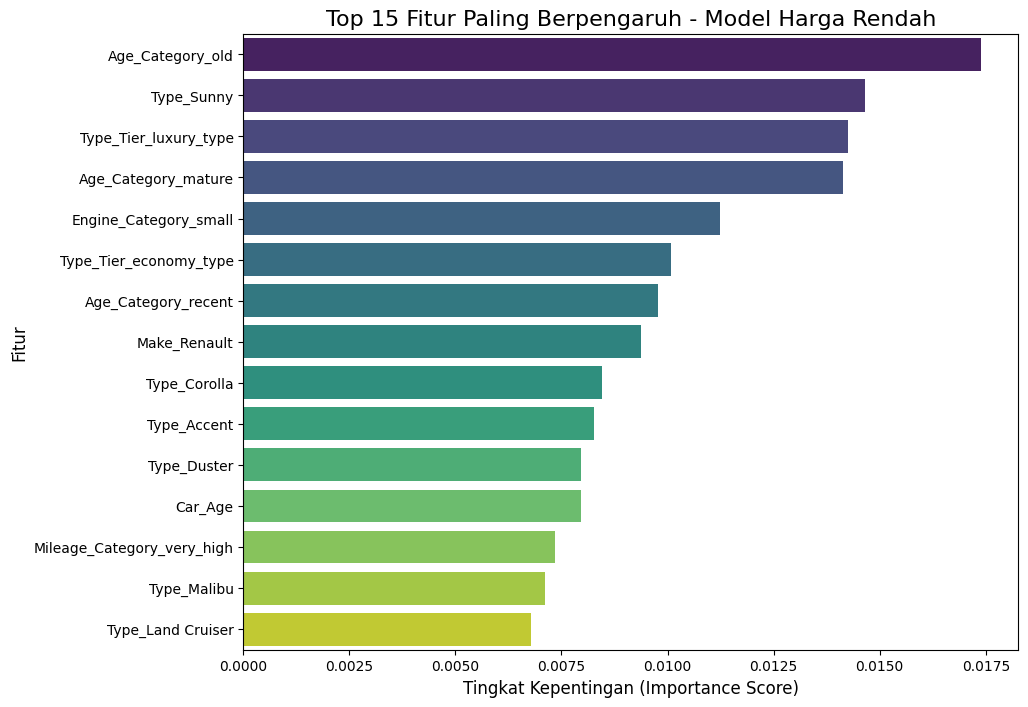

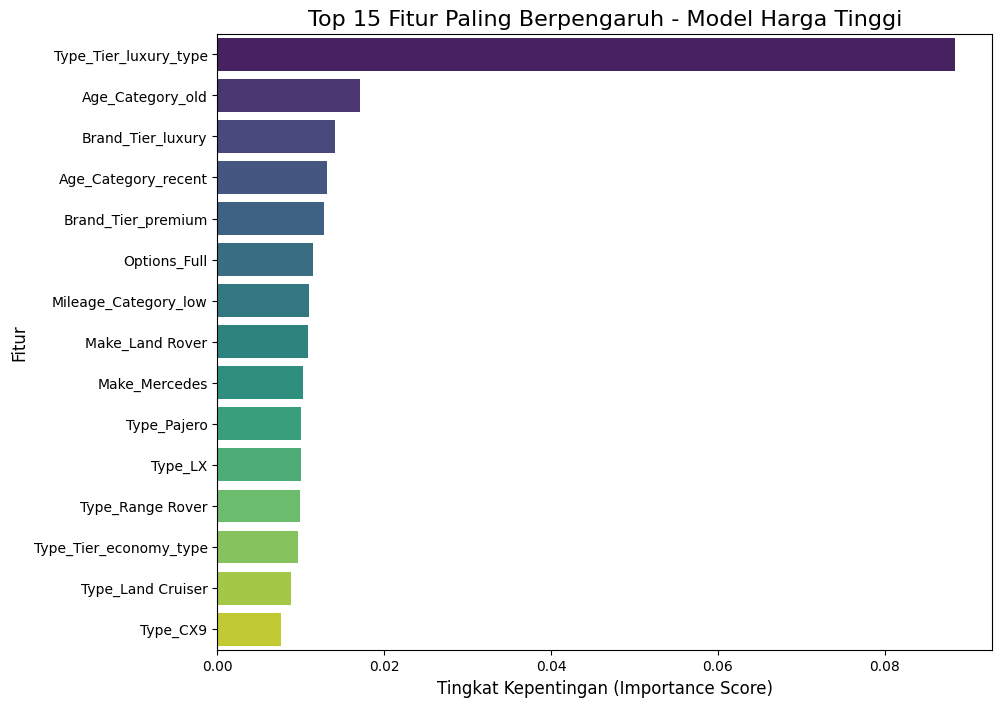

In [ ]:
# Feture Importance
import matplotlib.pyplot as plt
import seaborn as sns

print("\nTahap 8: Menganalisis Fitur Paling Berpengaruh untuk Setiap Model...")

def plot_feature_importance(pipeline, df_segment, title):
    """
    Fungsi untuk mengekstrak dan memvisualisasikan feature importance dari pipeline.
    """
    # 1. Ekstrak nama fitur setelah diproses oleh ColumnTransformer
    preprocessor = pipeline.named_steps['preprocessor']
    regressor = pipeline.named_steps['regressor']
    
    # Dapatkan nama fitur numerik (yang sudah di-scale)
    numeric_features = preprocessor.transformers_[0][2]
    
    # Dapatkan nama fitur kategorikal (yang sudah di-OHE)
    ohe_categories = preprocessor.named_transformers_['cat'].categories_
    categorical_features_ohe = []
    for i, col in enumerate(preprocessor.transformers_[1][2]):
        for category in ohe_categories[i]:
            categorical_features_ohe.append(f"{col}_{category}")
            
    # Gabungkan semua nama fitur
    all_feature_names = list(numeric_features) + categorical_features_ohe
    
    # 2. Dapatkan nilai importance dari model XGBoost
    importances = regressor.feature_importances_
    
    # 3. Buat DataFrame untuk visualisasi
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(15) # Ambil 15 teratas
    
    # 4. Buat plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top 15 Fitur Paling Berpengaruh - {title}', fontsize=16)
    plt.xlabel('Tingkat Kepentingan (Importance Score)', fontsize=12)
    plt.ylabel('Fitur', fontsize=12)
    plt.show()

# Visualisasi untuk model harga rendah
# Kita butuh salah satu segmen data training untuk mencocokkan pipeline
plot_feature_importance(pipeline_low_tuned, df_train_low, "Model Harga Rendah")

# Visualisasi untuk model harga tinggi
plot_feature_importance(pipeline_high_tuned, df_train_high, "Model Harga Tinggi")

In [ ]:
# Plot Prediksi vs Aktual

y_actual_low = df_test_low['Price']
y_pred_low = np.expm1(pipeline_low_tuned.predict(df_test_low.drop(columns=['Price', 'Price_log'])))

y_actual_high = df_test_high['Price']
y_pred_high = np.expm1(pipeline_high_tuned.predict(df_test_high.drop(columns=['Price', 'Price_log'])))

# Gabungkan semuanya
y_actual_full = pd.concat([y_actual_low, y_actual_high])
y_pred_full = np.concatenate([y_pred_low, y_pred_high])

# Buat plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_actual_full, y=y_pred_full, alpha=0.5)
plt.plot([y_actual_full.min(), y_actual_full.max()], [y_actual_full.min(), y_actual_full.max()], '--r', linewidth=2) # Garis prediksi sempurna
plt.title('Harga Aktual vs. Harga Prediksi', fontsize=16)
plt.xlabel('Harga Aktual (SAR)', fontsize=12)
plt.ylabel('Harga Prediksi (SAR)', fontsize=12)
plt.show()


Membuat Partial Dependence Plots...


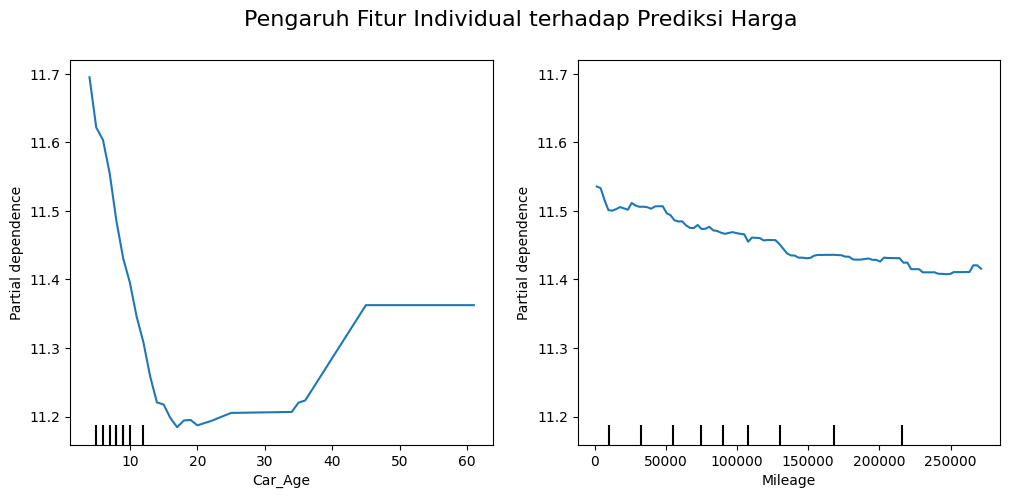

In [7]:
from sklearn.inspection import PartialDependenceDisplay

# Kita akan menganalisis model harga tinggi karena memiliki data yang lebih bervariasi
# Ambil pipeline dan data training yang sesuai
model_to_analyze = pipeline_high_tuned
X_train_to_analyze = df_train_high.drop(columns=['Price', 'Price_log'])

# Buat PDP untuk 'Car_Age' dan 'Mileage'
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
features_to_plot = ['Car_Age', 'Mileage']

print("\nMembuat Partial Dependence Plots...")
display = PartialDependenceDisplay.from_estimator(
    model_to_analyze,
    X_train_to_analyze,
    features=features_to_plot,
    ax=ax
)
fig.suptitle('Pengaruh Fitur Individual terhadap Prediksi Harga', fontsize=16)
plt.show()

In [ ]:

import shap

# Ambil satu sampel data dari test set harga tinggi
sample_car = df_test_high.drop(columns=['Price', 'Price_log']).iloc[[0]] 

# Ambil pipeline yang sesuai
model_to_explain = pipeline_high_tuned
preprocessor = model_to_explain.named_steps['preprocessor']
regressor = model_to_explain.named_steps['regressor']

# Transformasikn data sampel
sample_car_transformed = preprocessor.transform(sample_car)
# Buat SHAP explaniner
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(sample_car_transformed)

# Dapatkan nama fitur setelah OHE
ohe_feature_names = model_to_explain.named_steps['preprocessor'].get_feature_names_out()

# Buat force plot
print(f"\nAnalisis SHAP untuk satu mobil spesifik:")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=ohe_feature_names)


Analisis SHAP untuk satu mobil spesifik:


### Conclusion

Berdasarkan pemodelan yang sudah dilakukan, fitur-fitur turunan (engineered features) seperti Car_Age, Brand_Tier, dan Type_Tier menjadi fitur yang paling berpengaruh terhadap Price. Pendekatan dengan membagi model menjadi dua "spesialis" (harga rendah dan harga tinggi) terbukti sangat efektif dalam mengatasi masalah prediksi pada data dengan distribusi yang sangat condong ke kanan.

Metrik evaluasi utama yang difokuskan pada model ini adalah nilai MAE & MAPE. Jika ditinjau dari nilai MAPE yang dihasilkan oleh model final setelah dilakukan hyperparameter tuning, kita dapat menyimpulkan bahwa:

Untuk mobil di segmen harga tinggi (di atas 49,000 SAR), perkiraan harga rata-rata akan meleset kurang lebih sebesar 11.5% dari harga seharusnya.

Untuk mobil di segmen harga rendah (di bawah 49,000 SAR), perkiraan harga rata-rata akan meleset kurang lebih sebesar 18.5% dari harga seharusnya.

Tentu, model ini masih memiliki keterbatasan. Penyebab utama error yang tersisa kemungkinan besar berasal dari terbatasnya fitur pada dataset yang bisa merepresentasikan aspek fisik dan riwayat kendaraan, seperti kondisi cat (baret/mulus), riwayat kecelakaan, catatan servis rutin, atau bahkan warna mobil, yang semuanya merupakan faktor penting dalam penentuan harga di dunia nyata.

Model ini sudah sangat solid dan dapat diimprovisasi lebih lanjut. Namun, kita sudah bisa melakukan A/B testing terhadap sistem model ini untuk mengetahui tingkat efektivitasnya dalam membantu pengguna (penjual dan pembeli) di platform.



### Recommendation

Lakukan A/B testing untuk menguji efektivitas sistem model ini. Skenarionya bisa dengan membandingkan dua grup penjual: Grup A yang tidak mendapat saran harga, dan Grup B yang mendapat saran harga dari model kita. Ukur metrik seperti kecepatan mobil terjual atau jumlah interaksi (klik/tawaran) pada iklan di kedua grup.

Lalu, hal-hal yang dapat dilakukan untuk mengembangkan model agar lebih baik lagi, seperti:

Analisis Error Secara Mendalam. Lakukan analisis pada prediksi dengan error tertinggi. Kelompokkan error ke dalam grup overestimation (prediksi terlalu tinggi) dan underestimation (prediksi terlalu rendah). Ambil 5% data dengan error paling ekstrem dari tiap grup, lalu analisis karakteristiknya. Apakah model selalu salah memprediksi merek tertentu? Atau mobil dengan Options 'Standard'? Wawasan dari sini akan menjadi panduan untuk iterasi feature engineering berikutnya.
<br><br>

Penambahan Fitur Kontekstual dari Data Tidak Terstruktur. Jika memungkinkan, penambahan fitur dari data selain data tabular akan sangat meningkatkan akurasi:

Analisis Teks (NLP): Gunakan teknik Natural Language Processing pada kolom deskripsi iklan (jika ada) untuk mengekstrak kata kunci seperti "kondisi seperti baru", "bekas tabrak", "servis rutin", "tangan pertama", lalu ubah menjadi fitur baru (misal: Condition_Score).

Analisis Gambar (Computer Vision): Jika ada foto mobil, model Computer Vision dapat dilatih untuk mendeteksi penyok, baret, atau bahkan menilai kebersihan interior untuk dijadikan fitur kuantitatif.
<br><br>

Mencoba Algoritma yang Lebih Canggih. Walaupun XGBoost sudah sangat kuat, kita bisa bereksperimen dengan model lain yang memiliki pendekatan berbeda, seperti:

CatBoost: Algoritma Gradient Boosting lain yang dikenal memiliki penanganan fitur kategorikal built-in yang sangat baik, yang mungkin bisa memberikan hasil lebih baik lagi untuk data kita yang kaya akan fitur kategori (Make, Type, Brand_Tier, Type_Tier, dll).

Model Neural Network untuk Tabular: Mencoba arsitektur seperti TabNet atau MLP (Multi-Layer Perceptron) sederhana bisa memberikan perspektif yang berbeda dalam menemukan pola data.
<br><br>

Membangun Model untuk Tujuan Bisnis Lain. Model regresi yang sudah dibangun ini bisa dimanfaatkan sebagai dasar untuk model lain. Contohnya, membuat model klasifikasi untuk melabeli sebuah iklan sebagai "Good Deal", "Fair Price", atau "Overpriced". Model ini akan menggunakan output prediksi harga dari model kita, membandingkannya dengan harga yang di-input penjual, lalu memberikan label. Ini memberikan nilai tambah yang sangat langsung dan mudah dipahami oleh pembeli.